# Regressione

In [2]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, RidgeCV
import seaborn.apionly as sns
import copy

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Esame del dataset Housing

Features:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
</pre>

Lettura del dataset in dataframe pandas

In [5]:
df = pd.read_csv('../dataset/housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.shape

(506, 14)

## Visualizzazione delle caratteristiche del dataset

Matrice delle distribuzioni mutue delle feature. Sulla diagonale, distribuzione delle singole feature

<Figure size 1152x576 with 0 Axes>

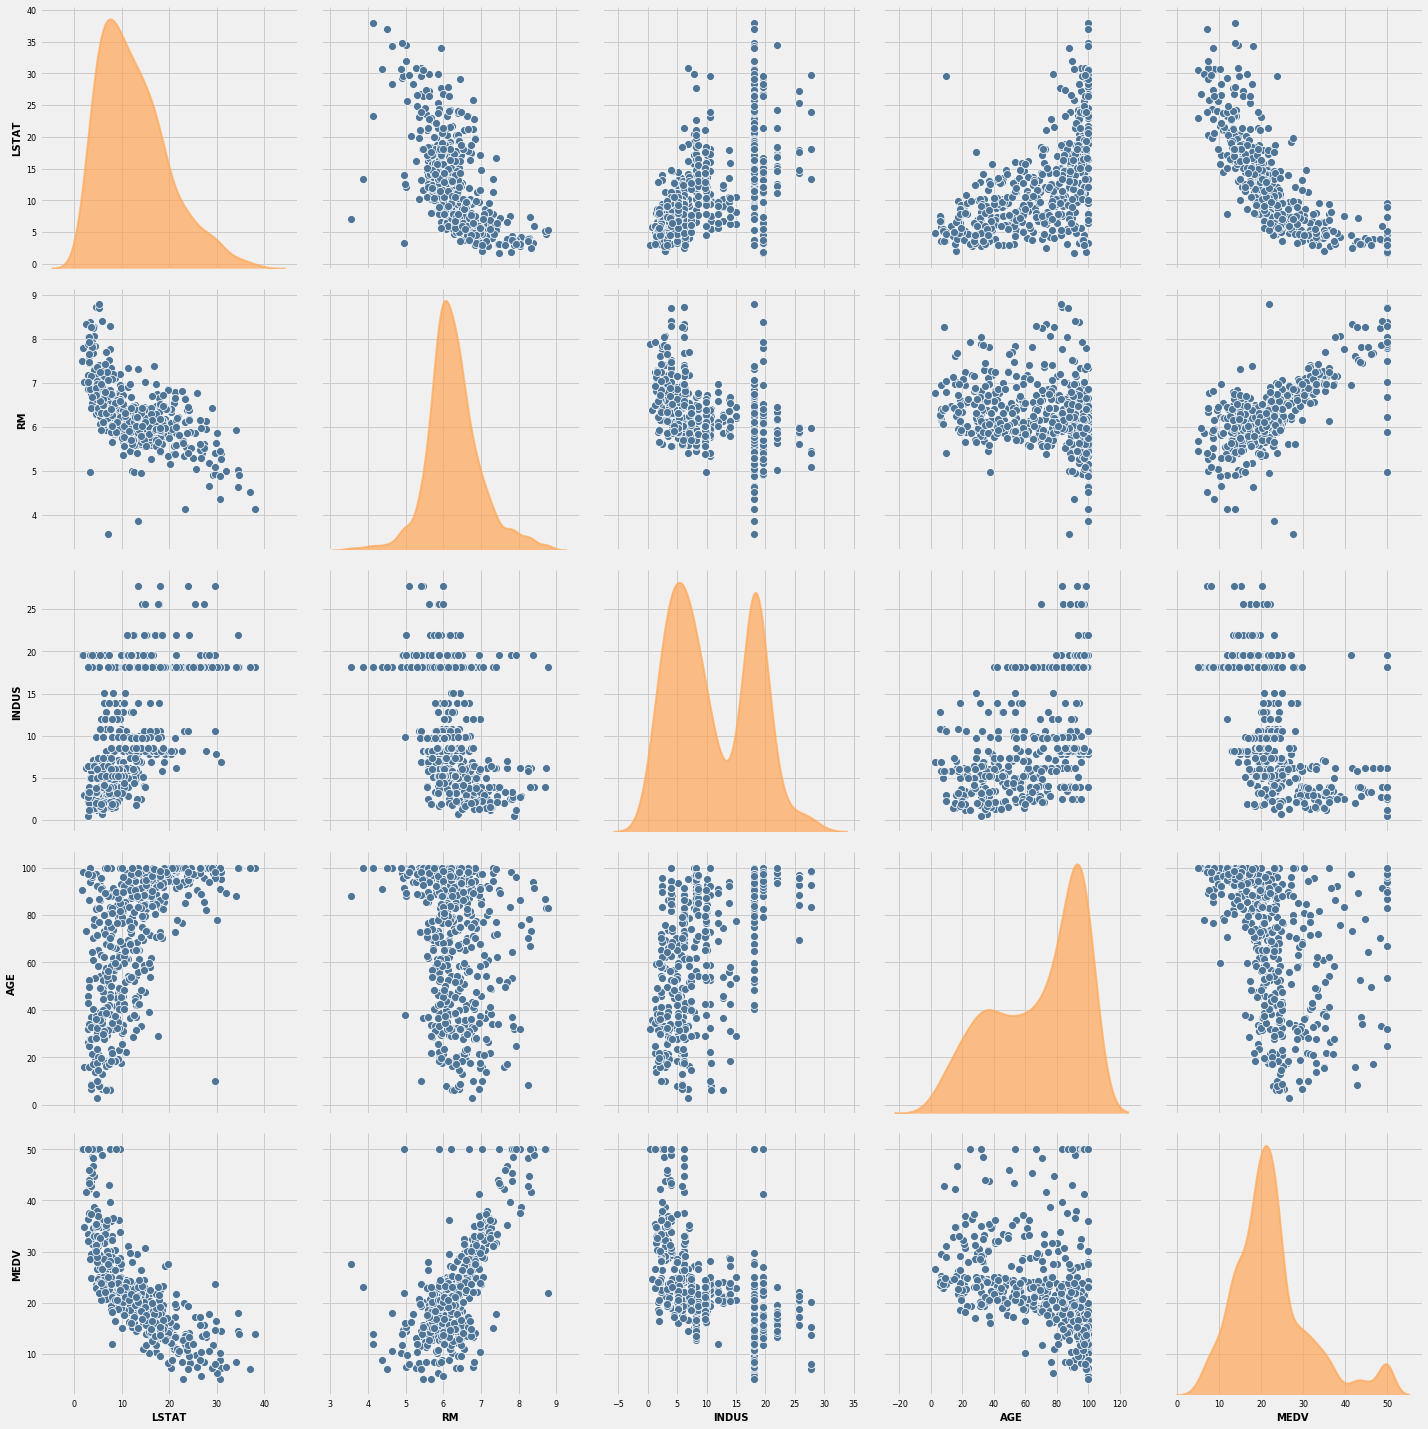

In [6]:
cols = ['LSTAT', 'RM', 'INDUS', 'AGE', 'MEDV']

fig = plt.figure(figsize=(16, 8))
sns.pairplot(df[cols], height=4, diag_kind='kde', 
             plot_kws=dict(color=colors[8]), 
             diag_kws=dict(shade=True, alpha=.7, color=colors[0]))
plt.show()

Visualizzazione della matrice di correlazione. Alla posizione $(i,j)$ il coefficiente di correlazione (lineare) tra le feature $i$ e $j$. Valore in $[-1,1]$: $1$ correlazione perfetta, $-1$ correlazione inversa perfetta, $0$ assenza di correlazione

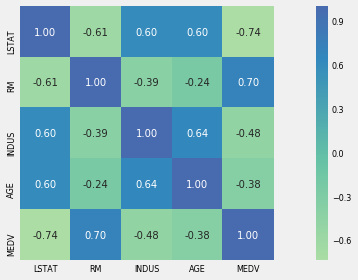

In [7]:
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(12,4))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols,
                 cmap = cmap)
plt.tight_layout()
plt.show()

### Regressione di MEDV rispetto a una sola feature

In [8]:
print("Feature utilizzabili: {0}".format(', '.join(map(str, df.columns[:-1]))))

Feature utilizzabili: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT


In [9]:
mi = mutual_info_regression(df[df.columns[:-1]], df[df.columns[-1]])
dmi = pd.DataFrame(mi, index=df.columns[:-1], columns=['mi']).sort_values(by='mi', ascending=False)
dmi.head(20)

,mi
LSTAT,0.666217
RM,0.529658
INDUS,0.472124
NOX,0.457762
PTRATIO,0.432389
TAX,0.363236
CRIM,0.350990
AGE,0.314053
DIS,0.296431
RAD,0.220153


Utilizza la feature più significativa

In [10]:
feat = dmi.index[0]

In [11]:
X = df[[feat]].values
y = df['MEDV'].values

In [13]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [14]:
results = []

Regressione lineare standard: la funzione di costo è $$C(\mathbf{w})=\frac{1}{2}\sum_i (y(\mathbf{w},\mathbf{x}_i) - t_i)^2$$

In [16]:
# crea modello di regressione lineare
r = LinearRegression()
# ne apprende i coefficienti sui dati disponibili
r = r.fit(X, y)

Misura di qualità utilizzata: 
- MSE (Errore quadratico medio) definito come $$\frac{1}{n}\sum_{i=1}^n (y(\mathbf{w},\mathbf{x}_i) - t_i)^2$$

In [17]:
p = r.predict(X)
# valuta MSE su dati e previsioni
mse = mean_squared_error(p,y)

In [20]:
mse

38.48296722989414

In [21]:
print('w0: {0:.3f}, w1: {1:.3f}, MSE: {2:.3f}'.format(r.intercept_, r.coef_[0],mse))

w0: 34.554, w1: -0.950, MSE: 38.483


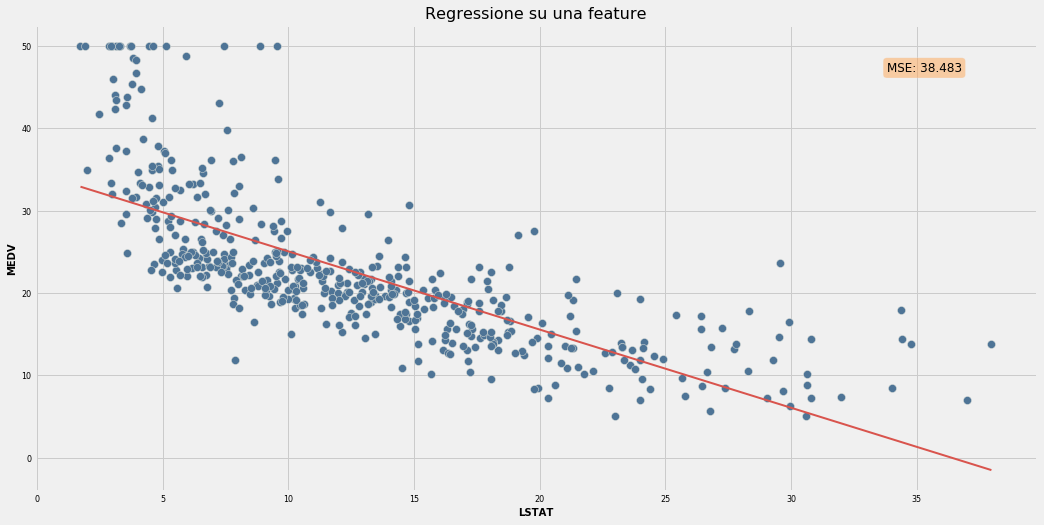

In [22]:
x = np.linspace(min(X),max(X),100).reshape(-1,1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor="xkcd:light grey")
plt.plot(x, r.predict(x), color=colors[2]) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature', fontsize=16)
plt.text(0.85, 0.9, 'MSE: {0:.3f}'.format(mse), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

Valuta il modello su test set al fine di evitare overfitting

In [23]:
# partiziona dataset in training (80%) e test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Crea una pipeline con il solo modello di regressione

In [24]:
pipe = Pipeline([('regression', LinearRegression())])
pipe = pipe.fit(X_train, y_train)
p_train = pipe.predict(X_train)
p_test = pipe.predict(X_test)
mse_train = mean_squared_error(p_train,y_train)
mse_test = mean_squared_error(p_test,y_test)

In [25]:
r = pipe.named_steps['regression']
print('w0: {0:.3f}, w1: {1:.3f}, MSE-train: {2:.3f}, MSE-test: {3:.3f}'.format(r.intercept_, r.coef_[0],mse_train, mse_test))

w0: 34.725, w1: -0.968, MSE-train: 39.408, MSE-test: 34.920


In [26]:
results.append(['Regression, 1 feature', mse_train, mse_test])

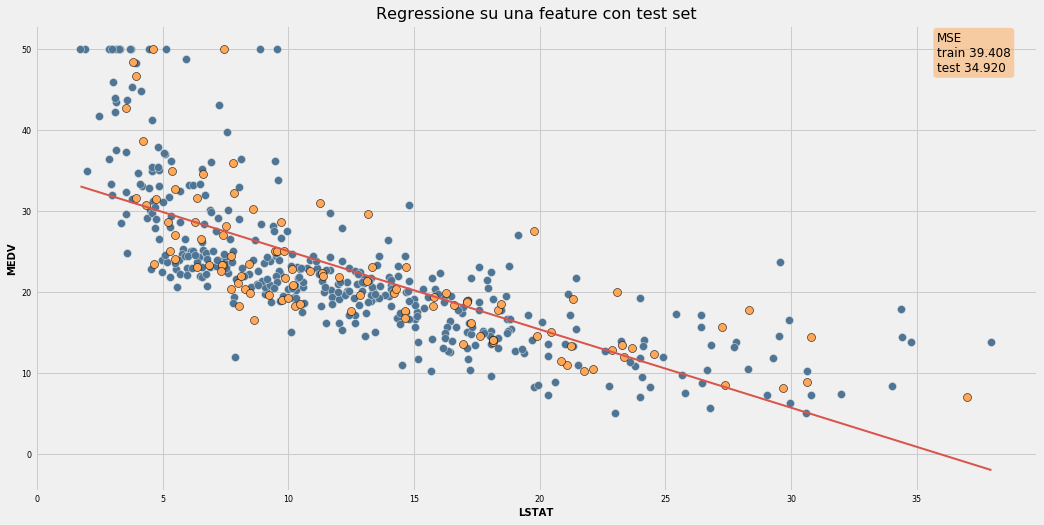

In [27]:
x = np.linspace(min(X),max(X),100).reshape(-1,1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X_train, y_train, c=colors[8], edgecolor="xkcd:light grey", label='Train')
plt.scatter(X_test, y_test, c=colors[0], edgecolor='black', label='Test')
plt.plot(x, pipe.predict(x), color=colors[2]) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature con test set', fontsize=16)
plt.text(0.9, 0.9, 'MSE\ntrain {0:.3f}\ntest {1:.3f}'.format(mse_train, mse_test), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

Aggiungi standardizzazione della feature, modificandone i valori in modo da ottenere media $0$ e varianza $1$. Utilizza le pipeline di scikit-learn per definire una sequenza di task: in questo caso i dati sono normalizzati mediante uno StandardScaler e sui risultati viene applicato il modello di regressione.

In [30]:
pipe = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
pipe = pipe.fit(X_train, y_train)

p_train = pipe.predict(X_train)
p_test = pipe.predict(X_test)
mse_train = mean_squared_error(p_train,y_train)
mse_test = mean_squared_error(p_test,y_test)

In [31]:
s = pipe.named_steps['scaler']
print('Scaling: mean: {0:.3f}, var: {1:.3f}, scale: {2:.3f}'.format(s.mean_[0], s.var_[0],s.scale_[0]))

Scaling: mean: 12.516, var: 49.944, scale: 7.067


In [33]:
r = pipe.named_steps['regression']
print('w0: {0:.3f}, w1: {1:.3f}, MSE-train: {2:.3f}, MSE-test: {3:.3f}'.format(r.intercept_, r.coef_[0],mse_train, mse_test))

w0: 22.498, w1: -6.923, MSE-train: 38.169, MSE-test: 39.794


In [34]:
results.append(['Regression, 1 feature, scaled', mse_train, mse_test])

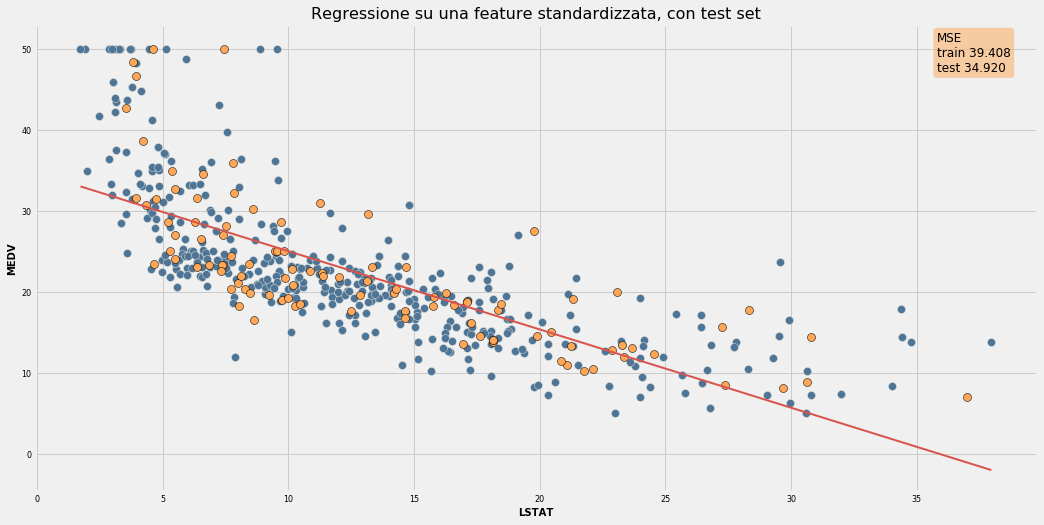

In [32]:
x = np.linspace(min(X),max(X),100).reshape(-1,1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X_train, y_train, c=colors[8], edgecolor='xkcd:light grey', label='Train')
plt.scatter(X_test, y_test, c=colors[0], edgecolor='black', label='Test')
plt.plot(x, pipe.predict(x), color=colors[2]) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.text(0.9, 0.9, 'MSE\ntrain {0:.3f}\ntest {1:.3f}'.format(mse_train, mse_test), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.title('Regressione su una feature standardizzata, con test set', fontsize=16)
plt.show()

La valutazione potrebbe dipendere eccessivamente dalla coppia training-test set (varianza). 
Utilizzo della cross validation per valutare il modello. Si applica un KFold per suddividere il training set $X$ in n_splits coppie (training set, test set)

In [36]:
pipe = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
k_fold = KFold(n_splits=3)
mse = []
preds = []
# itera su tutte le coppie (training set - test set)
for train, test in k_fold.split(X):
    # effettua l'apprendimento dei coefficienti sul training set
    r = pipe.fit(X[train], y[train])
    # appende in una lista il modello di regressione appreso
    preds.append(copy.deepcopy(r))
    mse.append(mean_squared_error(r.predict(X[test]),y[test]))
for i,r in enumerate(preds):
    c = [r.named_steps['scaler'].scale_[0], r.named_steps['scaler'].mean_[0], r.named_steps['regression'].intercept_, r
                  .named_steps['regression'].coef_[0]]
    print('Fold: {0:2d}, mean:{1:.3f}, scale: {2:.3f}, w0: {3:.3f}, w1: {4:.3f}, MSE test set: {5:.3f}'.format(i, c[0],c[1],c[2],c[3],mse[i]))
# restituisce le medie dei coefficienti e del MSE su tutti i fold
print('\nMSE - media: {0:.3f}, dev.standard: {1:.3f}'.format(np.mean(mse), np.std(mse)))

Fold:  0, mean:7.425, scale: 12.688, w0: 22.902, w1: -7.570, MSE test set: 28.353
Fold:  1, mean:7.286, scale: 14.768, w0: 19.533, w1: -5.805, MSE test set: 65.920
Fold:  2, mean:5.952, scale: 10.509, w0: 25.156, w1: -5.817, MSE test set: 38.151

MSE - media: 44.141, dev.standard: 15.911


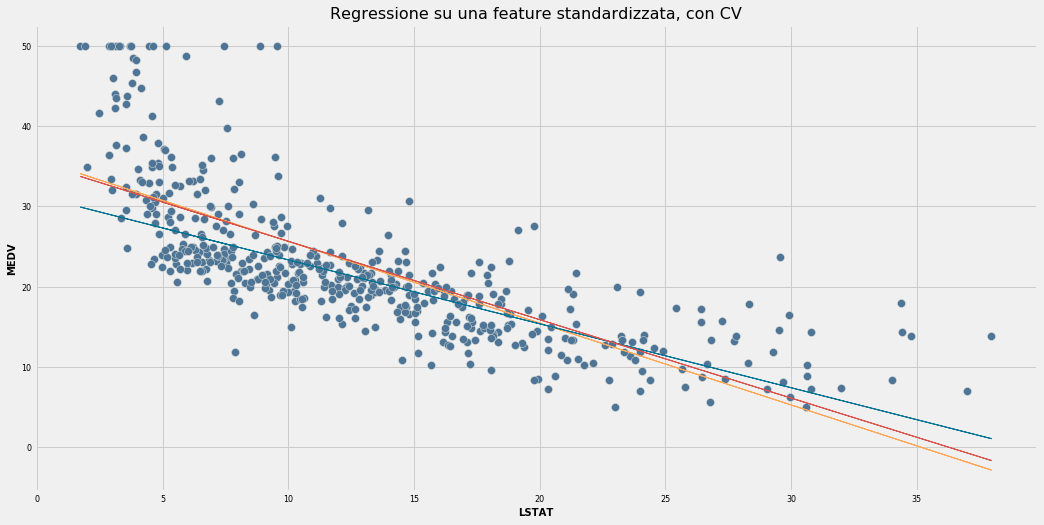

In [38]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
for i, r in enumerate(preds):
    plt.plot(X, r.predict(X), color=colors[i%7], linewidth=1) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature standardizzata, con CV', fontsize=16)
plt.show()

Utilizza la funzione cross_val_score di scikit-learn per effettuare la cross validation

In [525]:
p = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
# apprende il modello su tutto il training set
r = p.fit(X, y)
# calcola costo derivante dall'applicazione del modello su tutto il dataset, quindi con possibile overfitting
mse = mean_squared_error(r.predict(X),y)
# effettua la cross validation, derivando il costo sul test set per tutti i fold
scores = cross_val_score(estimator=p, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
# calcola costo medio su tutti i fold
mse_cv = -scores.mean()

In [526]:
results.append(['Regression, 1 feature, scaled, CV', mse, mse_cv])

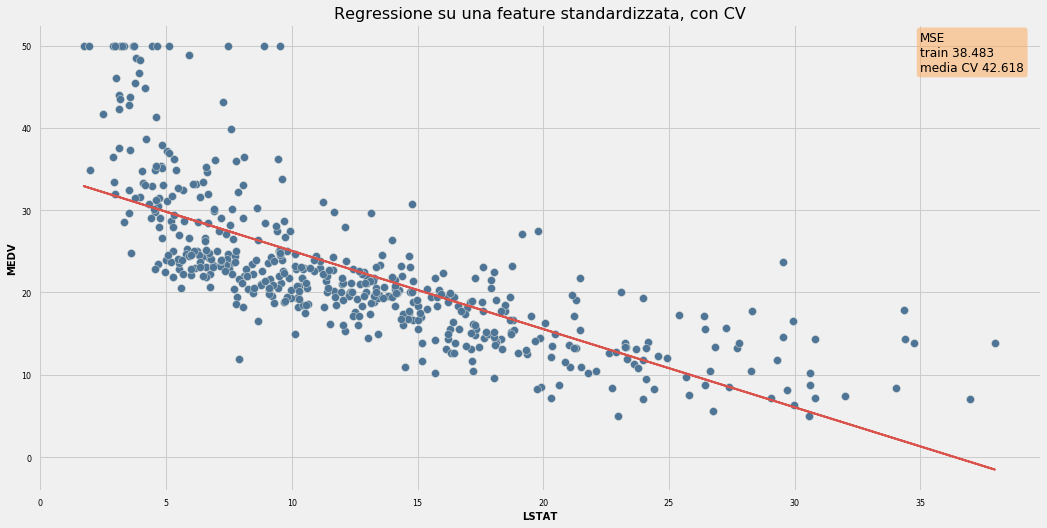

In [527]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
plt.plot(X, r.predict(X), color=colors[2]) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature standardizzata, con CV', fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

### Regressione con regolazione

Utilizza un modello con regolazione L1 (Lasso): la funzione di costo è $$C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}\sum_j |w_j|$$ 

In [39]:
#fissa un valore per l'iperparametro
alpha = 0.5
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=alpha))])
r = p.fit(X, y)
mse = mean_squared_error(r.predict(X),y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

In [40]:
results.append(['Regression L1, 1 feature, scaled, CV, alpha=0.5', mse, mse_cv])

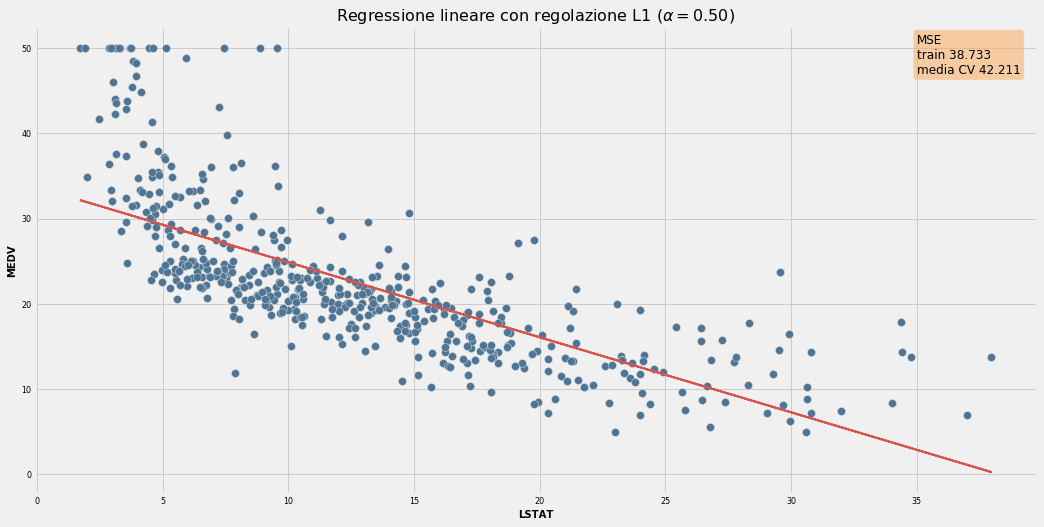

In [41]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
plt.plot(X, r.predict(X), color=colors[2]) 
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title(r'Regressione lineare con regolazione L1 ($\alpha={0:.2f}$)'.format(alpha), fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

Applica un modello con regolazione L2 (Ridge): la funzione di costo è $$C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}\sum_j w_j^2$$

In [42]:
#fissa un valore per l'iperparametro
alpha = 0.5
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()

In [43]:
results.append(['Regression L2, 1 feature, scaled, CV, alpha=0.5', mse, mse_cv])

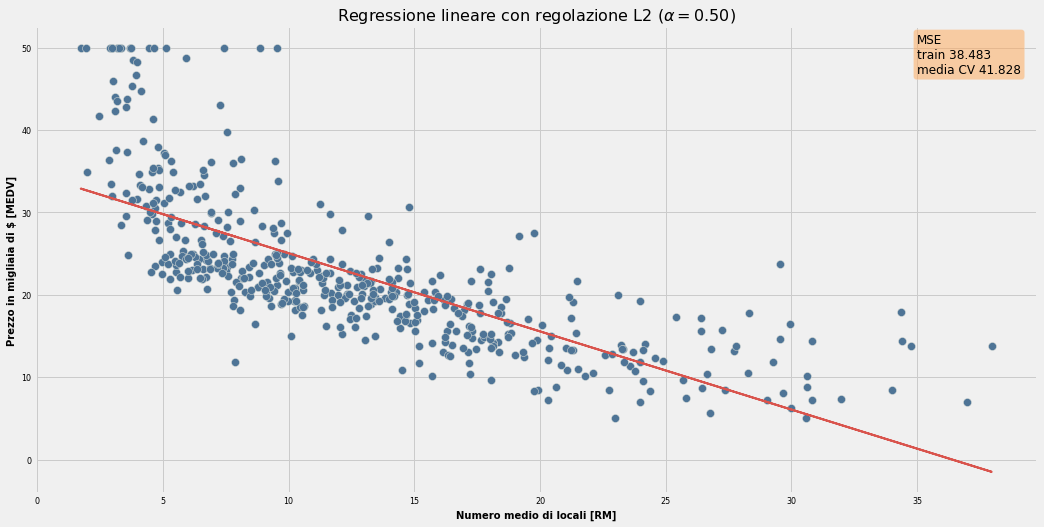

In [44]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
plt.plot(X, r.predict(X), color=colors[2]) 
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con regolazione L2 ($\alpha={0:.2f}$)'.format(alpha), fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

Applica un modello con regolazione Elastic Net: la funzione di costo è $$C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}(\gamma\sum_j |w_j|+(1-\gamma)\sum_j w_j^2)$$

In [45]:
alpha = 0.5
gamma = 0.3
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()

In [46]:
results.append(['Regression Elastic Net, 1 feature, scaled, CV, alpha=0.5, gamma=0.3', mse, mse_cv])

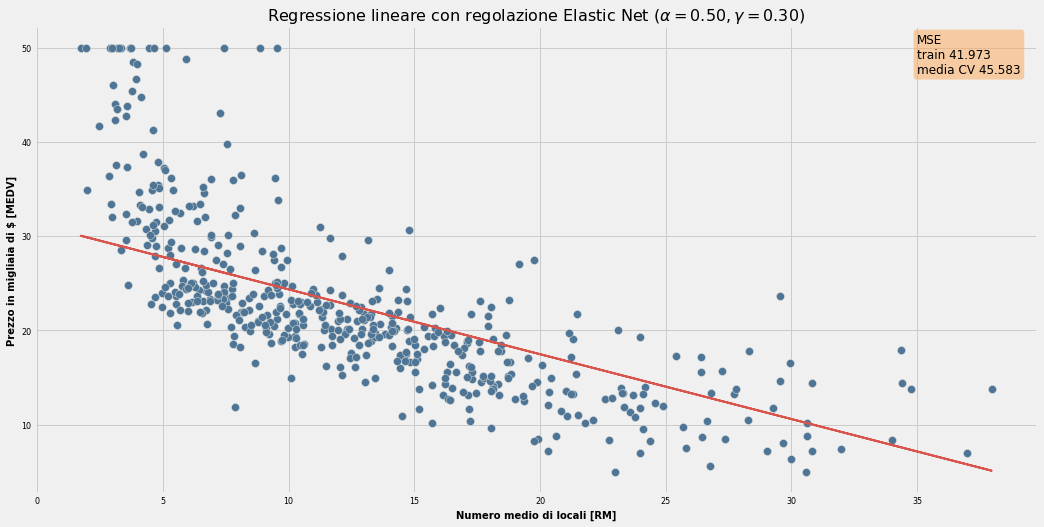

In [47]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
plt.plot(X, r.predict(X), color=colors[2]) 
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con regolazione Elastic Net ($\alpha={0:.2f}, \gamma={1:.2f}$)'.format(alpha, gamma), fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, 
         bbox=bbox_props)
plt.show()

## Funzioni base polinomiali

Regressione lineare standard con funzioni base polinomiali. Utilizza PolynomialFeatures di scikit-learn, che implementa funzioni base polinomiali fino al grado dato

In [683]:
deg = 3
pipe_regr = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', LinearRegression())])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()

In [686]:
results.append(['Regression, Polynomial, 1 feature, scaled, degree={0:d}, CV'.format(deg), mse, mse_cv])

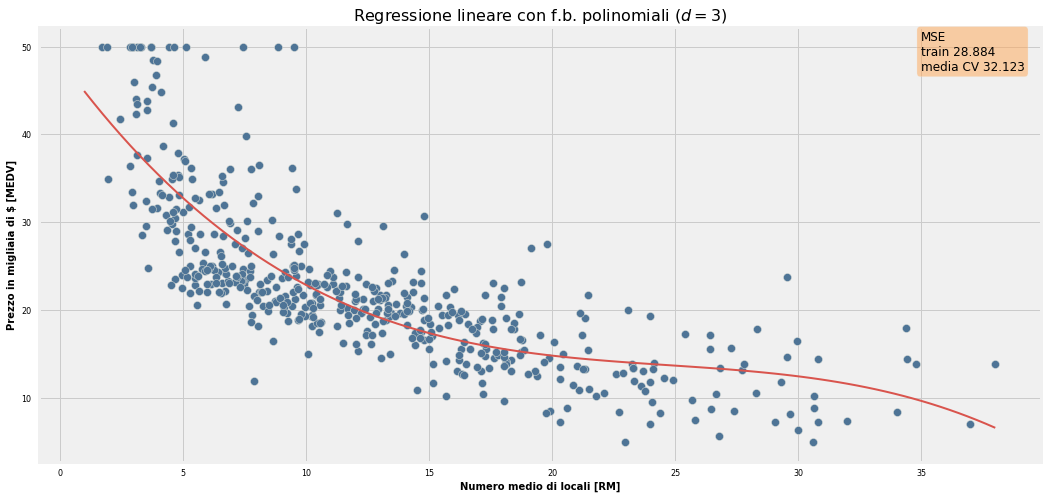

In [687]:
xmin = np.floor(min(X)[0])
xmax = np.ceil(max(X)[0])
x = np.linspace(xmin,xmax,100).reshape(-1, 1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='xkcd:light grey')
plt.plot(x, r.predict(x), color=colors[2]) 
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con f.b. polinomiali ($d={0:3d}$)'.format(deg), fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, bbox=bbox_props)
plt.show()

Visualizzazione dei residui: differenze $y_i-t_i$ in funzione di $y_i$

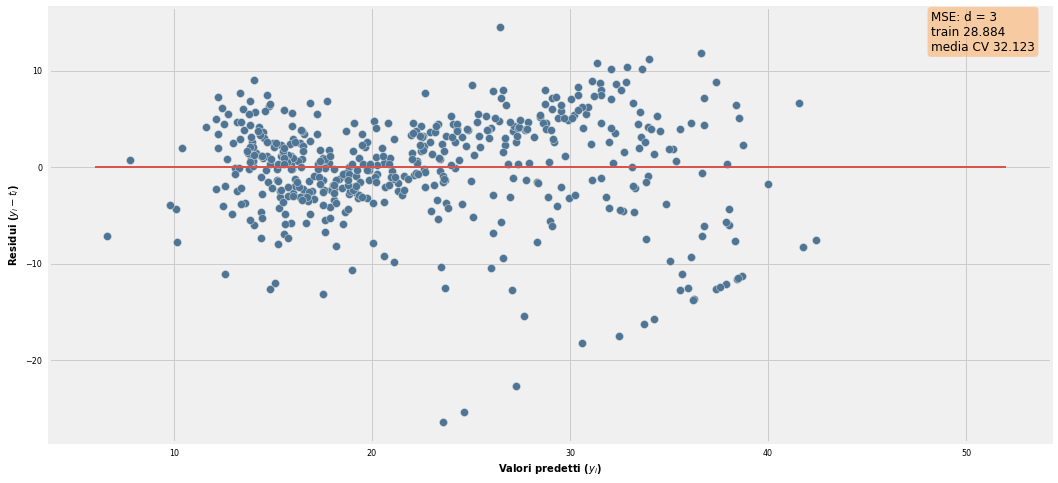

In [688]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y), c=colors[8], edgecolor='xkcd:light grey')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.text(0.88, 0.9, 'MSE: d = {0:d}\ntrain {1:.3f}\nmedia CV {2:.3f}'.format(deg, mse, mse_cv), fontsize=12, transform=ax.transAxes, 
         bbox=bbox_props)
plt.show()

In [689]:
res = []
for deg in range(1,30):
    r = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', LinearRegression())]).fit(X, y)
    scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
    mse = mean_squared_error(r.predict(X),y)
    mse_cv = -scores.mean()
    res.append([deg, mse, mse_cv])

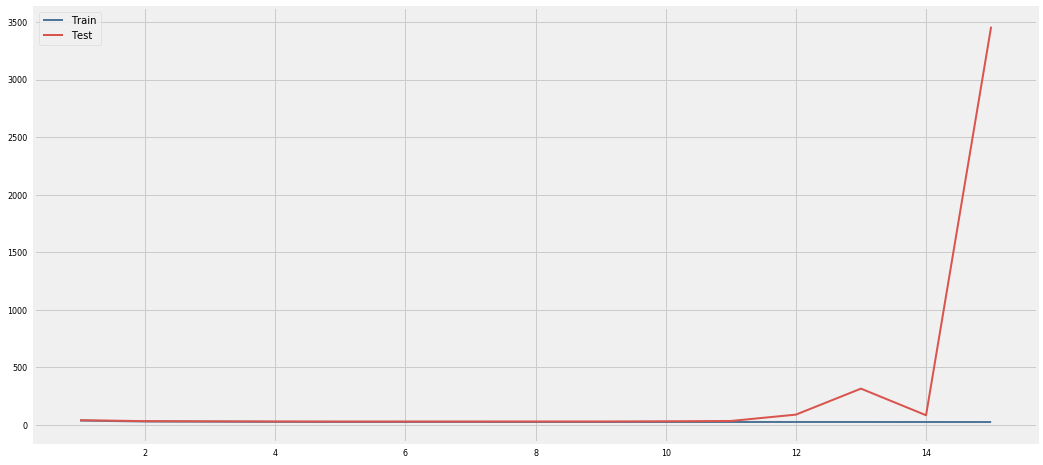

In [690]:
top = 15
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot([r[0] for r in res[:top]],  [r[1] for r in res[:top]], color=colors[8],label=r'Train') 
plt.plot([r[0] for r in res[:top]],  [r[2] for r in res[:top]], color=colors[2],label=r'Test') 
l=plt.legend()

In [691]:
alpha = 1
deg = 3
pipe_regr = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', Lasso(alpha=alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')

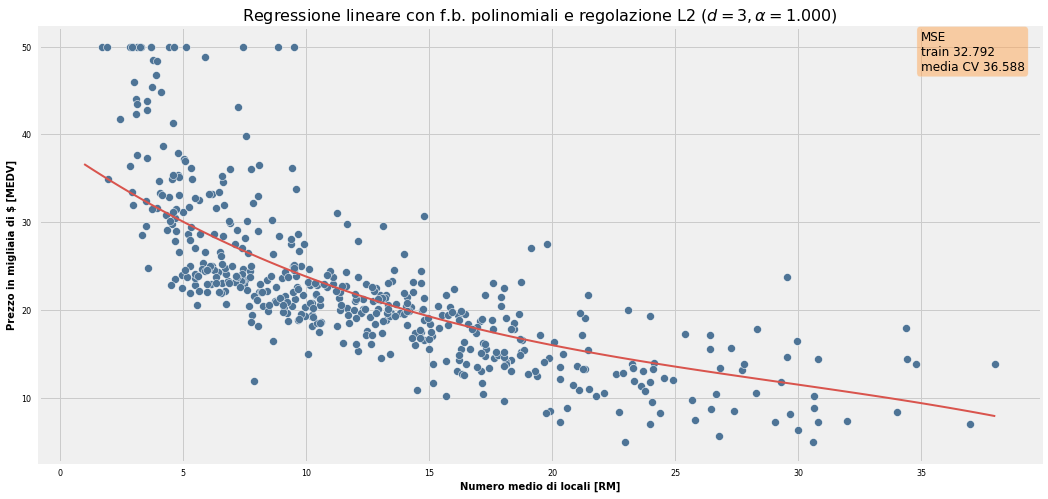

In [692]:
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()
xmin = np.floor(min(X)[0])
xmax = np.ceil(max(X)[0])
x = np.linspace(xmin,xmax,100).reshape(-1, 1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[8], edgecolor='white')
plt.plot(x, r.predict(x), color=colors[2]) 
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con f.b. polinomiali e regolazione L2 ($d={0:3d}, \alpha={1:.3f}$)'.format(deg, alpha), fontsize=16)
plt.text(0.88, 0.9, 'MSE\ntrain {0:.3f}\nmedia CV {1:.3f}'.format(mse, mse_cv), fontsize=12, transform=ax.transAxes, 
         bbox=bbox_props)
plt.show()

In [693]:
res = []
for deg in range(1,20):
    r = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', Lasso(alpha=alpha))]).fit(X, y)
    scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
    mse = mean_squared_error(r.predict(X),y)
    mse_cv = -scores.mean()
    res.append([deg, mse, mse_cv])

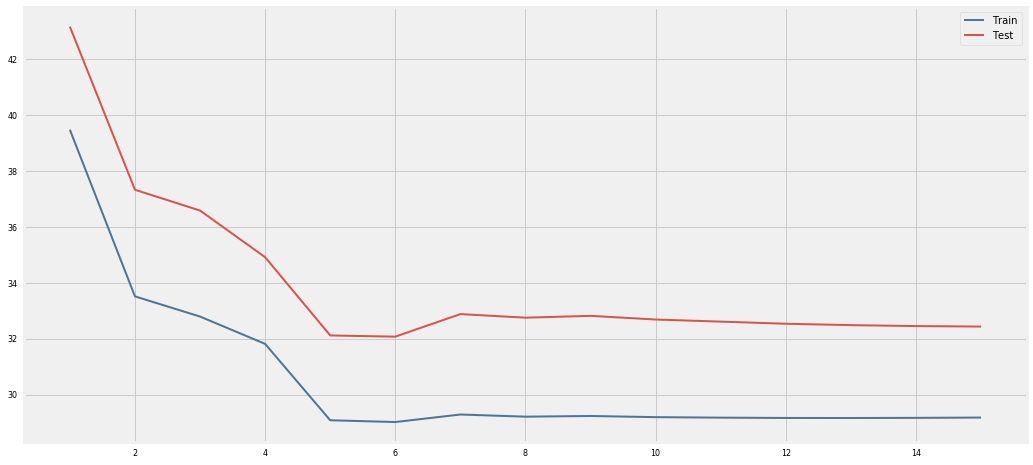

In [694]:
top = 15
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot([r[0] for r in res[:top]],  [r[1] for r in res[:top]], color=colors[8],label=r'Train') 
plt.plot([r[0] for r in res[:top]],  [r[2] for r in res[:top]], color=colors[2],label=r'Test') 
l=plt.legend()

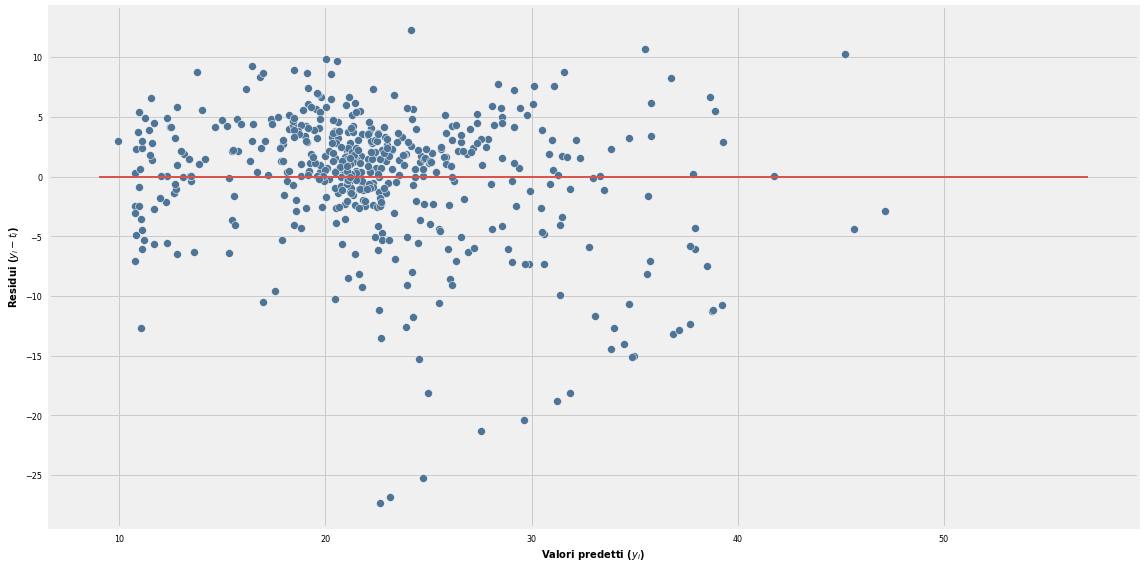

In [695]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),c=colors[8], edgecolor='white',label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.tight_layout()
plt.show()

## Regressione su tutte le feature

In [696]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [697]:
r = LinearRegression()
r.fit(X, y)
print('MSE: {0:.3f}'.format(mean_squared_error(r.predict(X),y)))

MSE: 21.895


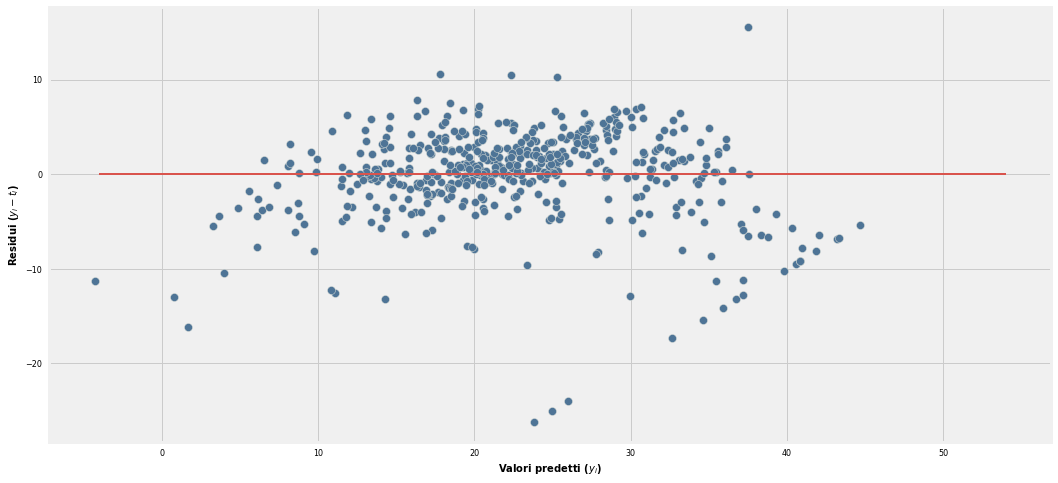

In [700]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y), c=colors[8], edgecolor='xkcd:light grey')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.show()

In [701]:
r = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
r.fit(X, y)
print('MSE: {0:.3f}'.format(mean_squared_error(r.predict(X),y)))

MSE: 21.895


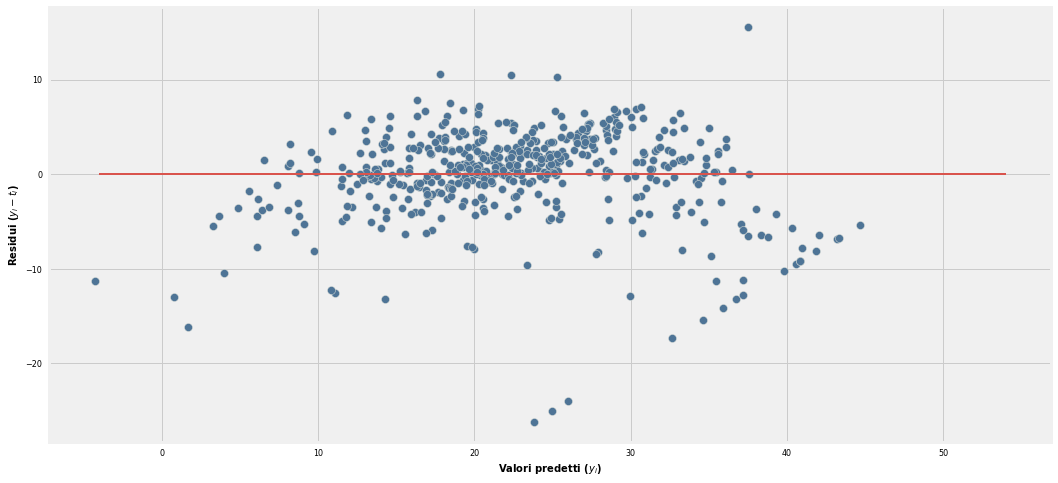

In [704]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y), c=colors[8], edgecolor='xkcd:light grey')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.show()

Applica cross-validation

In [721]:
r = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
scores = cross_val_score(estimator=r, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
print('MSE')
print(-scores)
print('media {0:.3f}, dev.standard {1:.3f}'.format(-scores.mean(), -scores.std()))

MSE
[12.46030057 26.04862111 33.07413798 80.76237112 33.31360656]
media 37.132, dev.standard -23.092


In [722]:
alpha = 0.5
r = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=alpha))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
print('MSE')
print(-scores)
print('media {0:.3f}, dev.standard {1:.3f}'.format(-scores.mean(), -scores.std()))

MSE
[ 9.32361618 27.30734484 42.23358277 79.26402738 29.088899  ]
media 37.443, dev.standard -23.389


In [730]:
alpha = 10
r = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=alpha))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
print('MSE')
print(-scores)
print('media {0:.3f}, dev.standard {1:.3f}'.format(-scores.mean(), -scores.std()))

MSE
[11.29705923 24.26948196 32.68855808 78.37508886 29.89441072]
media 35.305, dev.standard -22.757


In [731]:
alpha = 0.5
gamma = 0.3
r = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
print('MSE')
print(-scores)
print('media {0:.3f}, dev.standard {1:.3f}'.format(-scores.mean(), -scores.std()))

MSE
[10.93665786 27.26068642 41.97544665 68.01123789 21.56551634]
media 33.950, dev.standard -19.760


LassoCV effettua la ricerca del miglior valore per $\alpha$

In [630]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', LassoCV(cv=7))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
best_alpha = pipe_regr.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.3f}'.format(best_alpha))
print('MSE: {0:.3f}'.format(-scores.mean()))

Miglior valore di alpha: 0.034
MSE: 36.372


In [733]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha = best_alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 34.243


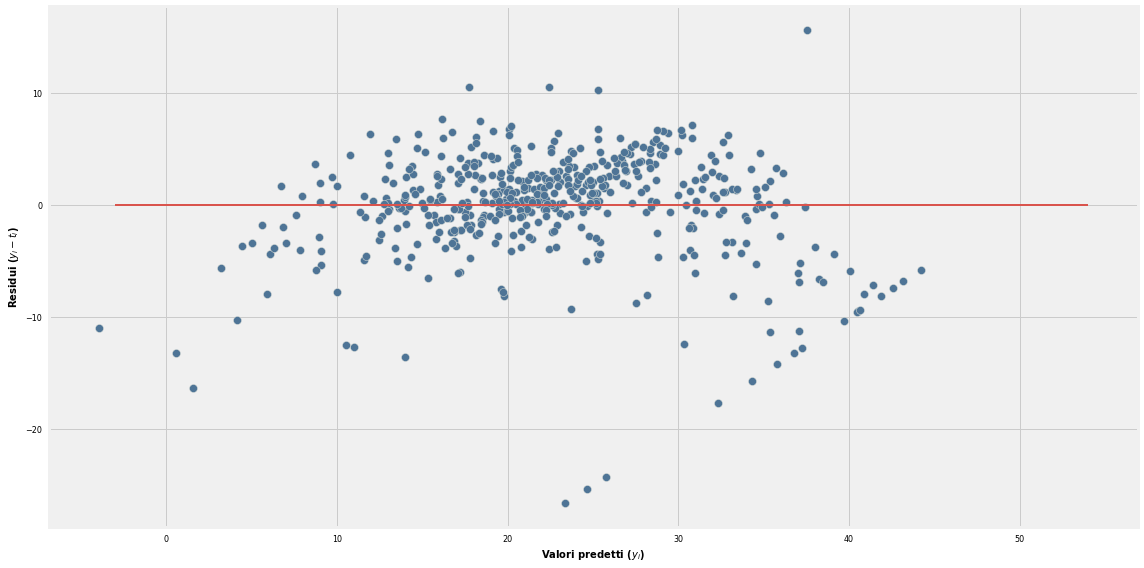

In [734]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y), c=colors[8], edgecolor='xkcd:light grey')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.tight_layout()
plt.show()

In [735]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', RidgeCV(cv=20))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
best_alpha = pipe_regr.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.3f}'.format(best_alpha))
print('MSE: {0:.3f}'.format(-scores.mean()))

Miglior valore di alpha: 10.000
MSE: 33.564


In [736]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 33.564


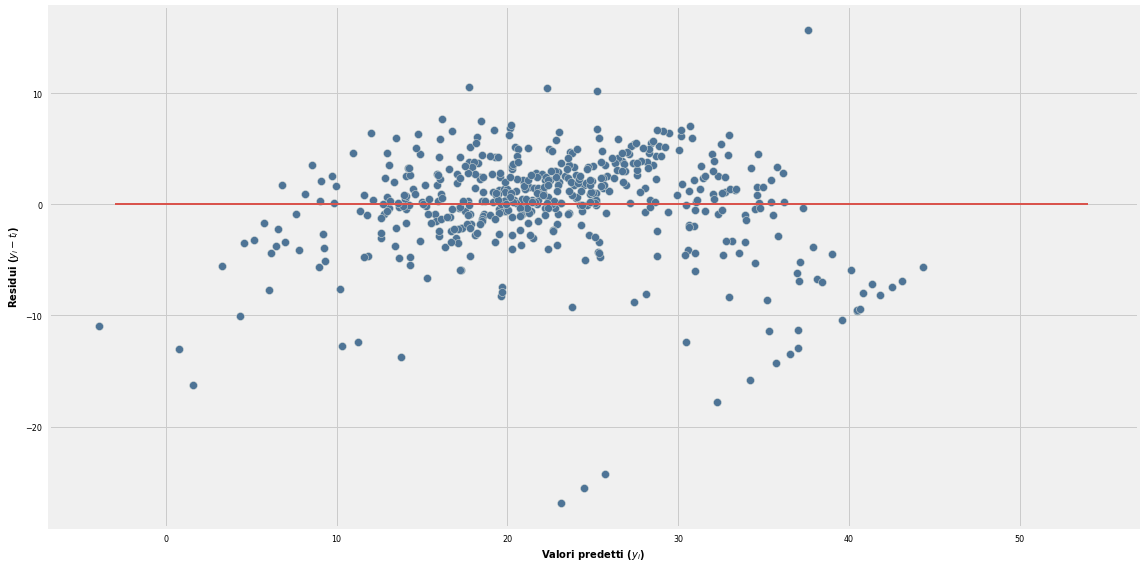

In [738]:
r = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=best_alpha))]).fit(X, y)

y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y), c=colors[8], edgecolor='xkcd:light grey')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[2], lw=2)
plt.tight_layout()
plt.show()

## Model selection

In [162]:
X = np.array(df[df.columns[:-1]])
y = np.array(df[df.columns[-1]])

### Lasso

Ricerca su griglia di valori per alpha in Lasso

In [163]:
domain = np.linspace(0,10,100)
cv = 10
scores = []
kf = KFold(n_splits=cv)
# considera tutti i valori di alpha in domain
for a in domain:
    # definisce modello con Lasso
    p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=a))])
    xval_err = 0
    # per ogni coppia train-test valuta l'errore sul test set del modello istanziato sulla base del training set
    for k, (train_index, test_index) in enumerate(kf.split(X,y)):
        p.fit(X[train_index], y[train_index])
        y1 = p.predict(X[test_index])
        err = y1 - y[test_index]
        xval_err += np.dot(err,err)
    # calcola erroe medio 
    score = xval_err/X.shape[0]
    scores.append([a,score])
scores = np.array(scores)

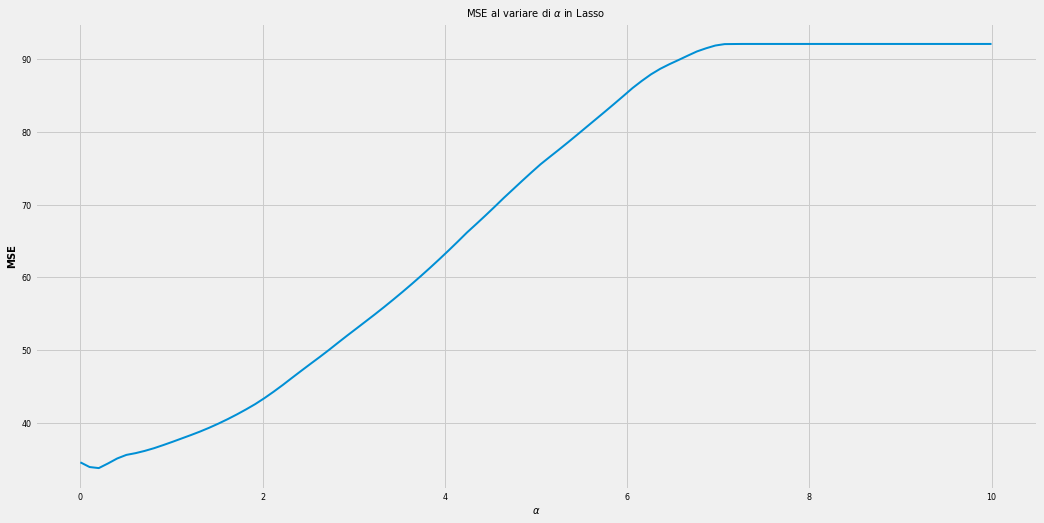

In [164]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(scores[:,0], scores[:,1]) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Lasso')
plt.show()

In [165]:
min_index = np.argmin(scores[:,1])
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(scores[min_index,0], scores[min_index,1]))

Miglior valore per alpha: 0.20202. MSE=33.748


Utilizzo di GridSearchCV

In [166]:
domain = np.linspace(0,10,100)
param_grid = [{'regression__alpha': domain}]
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso())])

clf = GridSearchCV(p, param_grid, cv=5, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
sc = -clf.cv_results_['mean_test_score']

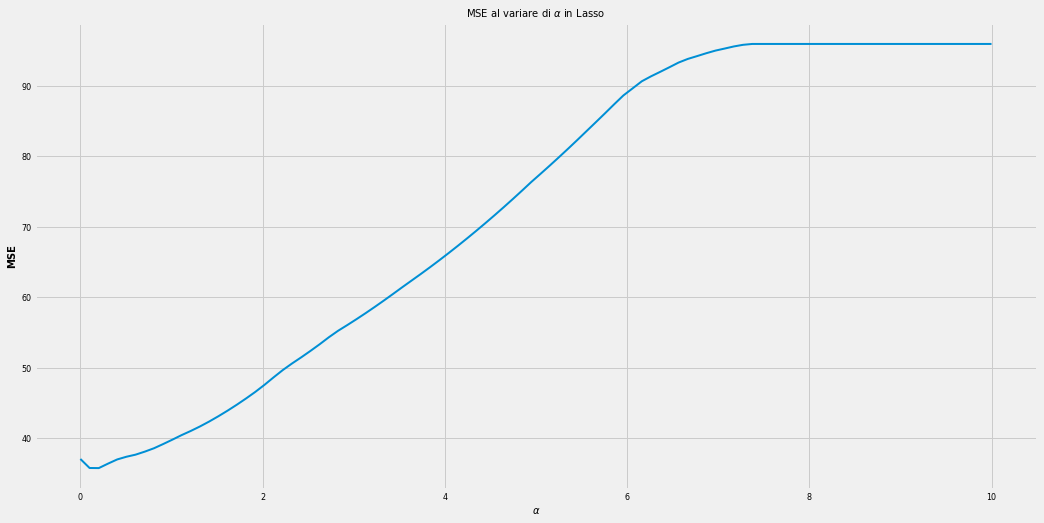

In [167]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(domain,sc) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Lasso')
plt.show()

In [168]:
min_index = np.argmin(sc)
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(domain[min_index], sc[min_index]))

Miglior valore per alpha: 0.20202. MSE=35.791


Utilizzo di LassoCV, che ricerca il miglior valore di $\alpha$ valutando lo score su un insieme di possibili valori mediante cross validation. 

In [169]:
domain=np.linspace(0,10,100)
p = Pipeline([('scaler', StandardScaler()),('regression', LassoCV(cv=10, alphas=domain))])
r = p.fit(X, y)
scores = np.mean(r.named_steps['regression'].mse_path_, axis=1)

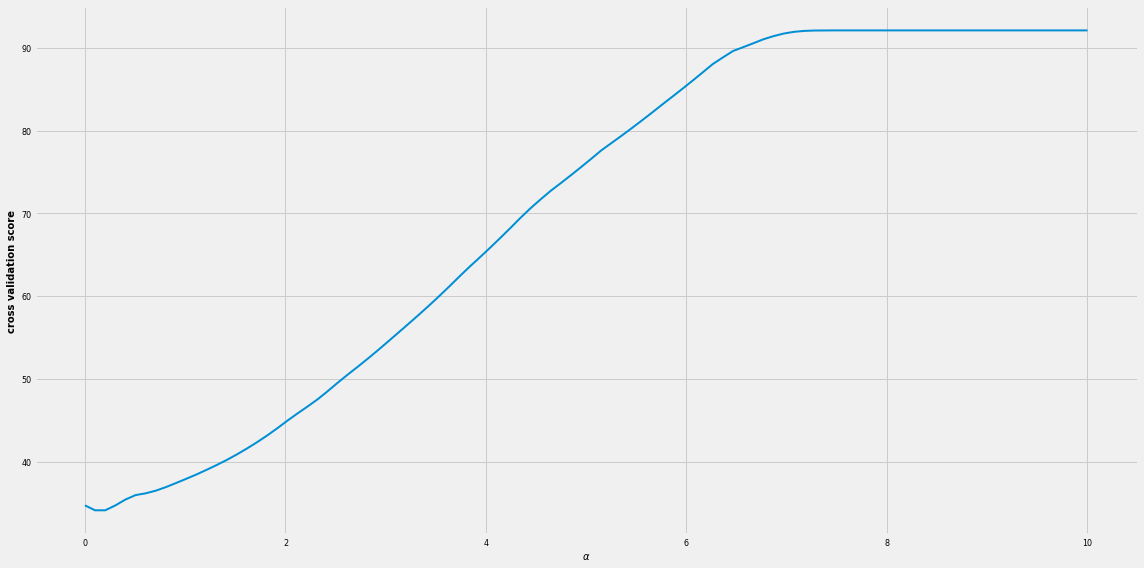

In [170]:
plt.figure(figsize=(16, 8))
plt.plot(r.named_steps['regression'].alphas_, scores)
plt.xlabel(r'$\alpha$')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [171]:
best_alpha = r.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.5f}'.format(best_alpha))
i, = np.where(r.named_steps['regression'].alphas_ == best_alpha)
print('MSE: {0:.5f}'.format(scores[i][0]))

Miglior valore di alpha: 0.10101
MSE: 34.11086


In [172]:
r.named_steps['regression'].coef_

array([-0.62930101,  0.70478583, -0.        ,  0.6572789 , -1.56979387,
        2.82785277, -0.        , -2.41484202,  1.18178304, -0.83505174,
       -1.92124196,  0.76130577, -3.72616312])

Valuta Lasso con il valore trovato per $\alpha$ sull'intero dataset

In [173]:
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha = best_alpha))])
scores = cross_val_score(estimator=p, X=X, y=y, cv=20, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 31.935


### Ridge

Ricerca su griglia di valori per alpha in Ridge

In [174]:
domain = np.linspace(80,120,100)
cv = 10
scores = []
kf = KFold(n_splits=cv)
for a in domain:
    p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=a))])
    xval_err = 0
    for k, (train_index, test_index) in enumerate(kf.split(X,y)):
        p.fit(X[train_index], y[train_index])
        y1 = p.predict(X[test_index])
        err = y1 - y[test_index]
        xval_err += np.dot(err,err)
    score = xval_err/X.shape[0]
    scores.append([a,score])
scores = np.array(scores)

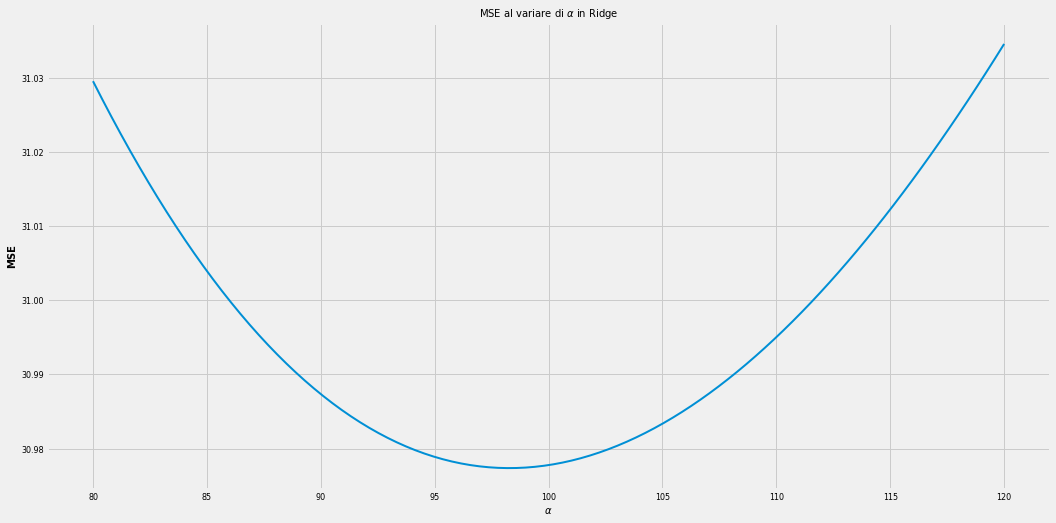

In [175]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(scores[:,0], scores[:,1]) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Ridge')
plt.show()

In [176]:
min_index = np.argmin(scores[:,1])
best_alpha = scores[min_index,0]
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(scores[min_index,0], scores[min_index,1]))

Miglior valore per alpha: 98.18182. MSE=30.977


Applica sul dataset con il valore trovato per $\alpha$

In [177]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 98.182, MSE: 31.098


Utilizzo di GridSearchCV

In [178]:
domain = np.linspace(80,120,100)
param_grid = [{'regression__alpha': domain}]
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge())])

clf = GridSearchCV(p, param_grid, cv=10, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
scores = -clf.cv_results_['mean_test_score']

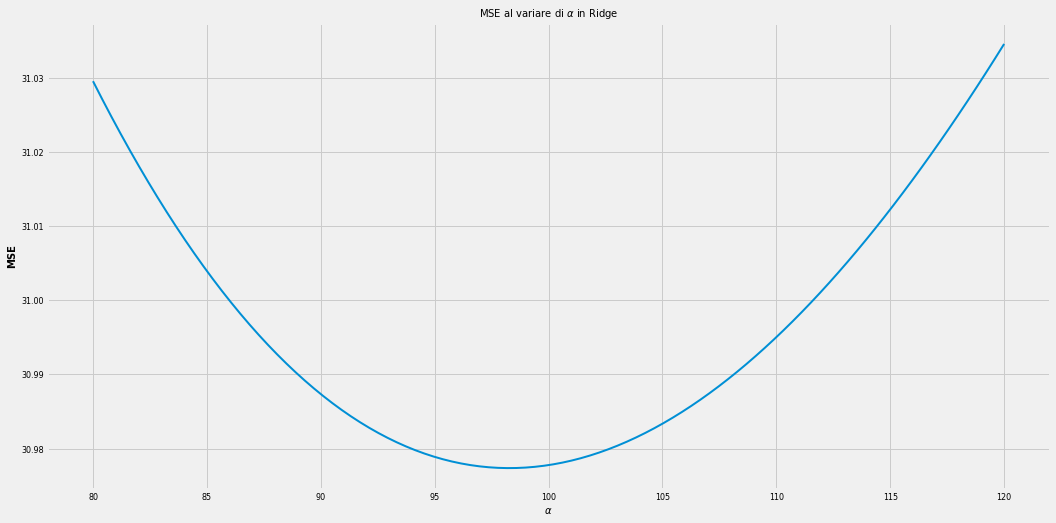

In [179]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(domain,scores) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Ridge')
plt.show()

In [180]:
min_index = np.argmin(scores)
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(domain[min_index], scores[min_index]))

Miglior valore per alpha: 98.18182. MSE=30.977


Applica sul dataset con il valore trovato per $\alpha$

In [181]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 98.182, MSE: 31.098


Utilizza RidgeCV, che ricerca il miglior valore di $\alpha$ valutando lo score su un insieme di possibili valori mediante cross validation

In [182]:
domain = np.linspace(0.1, 10, 100)
p = Pipeline([('scaler', StandardScaler()),('regression', RidgeCV(alphas=domain, store_cv_values = True))])
r = p.fit(X, y)
scores = np.mean(r.named_steps['regression'].cv_values_, axis=0)

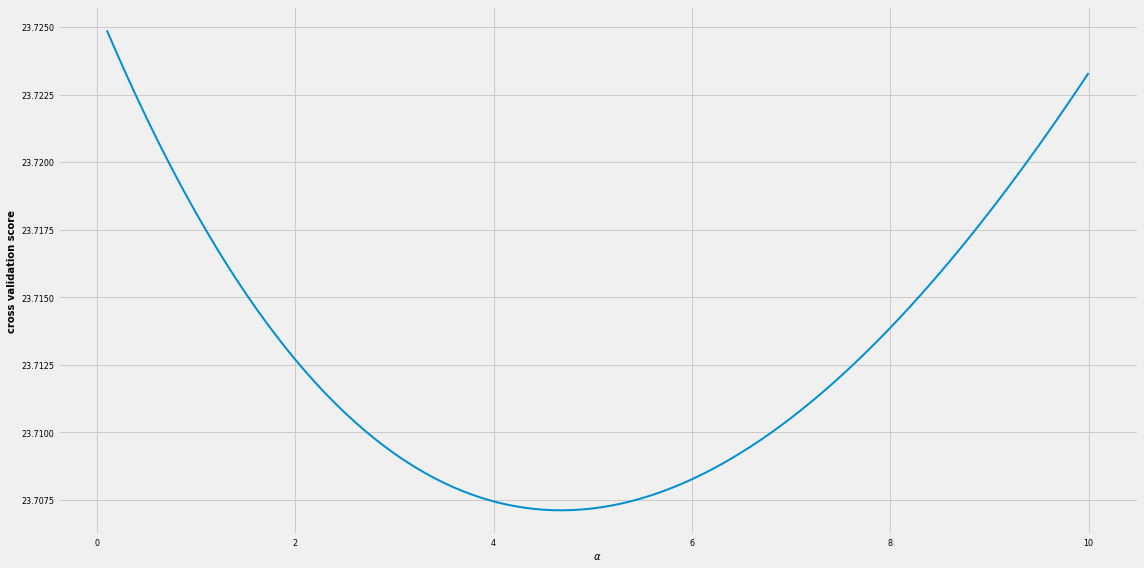

In [183]:
plt.figure(figsize=(16, 8))
plt.plot(domain, scores)
plt.xlabel(r'$\alpha$')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [184]:
best_alpha = p.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.6f}'.format(best_alpha))
i, = np.where(domain == best_alpha)
print('score: {0:.3f}'.format(scores[i][0]))

Miglior valore di alpha: 4.700000
score: 23.707


Valuta Ridge con il valore trovato per  α
  sull'intero dataset

In [185]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 4.700, MSE: 34.106


In [186]:
r.named_steps['regression'].coef_

array([-0.89221393,  1.01585864,  0.04211077,  0.69593044, -1.93339989,
        2.71062672, -0.00773909, -2.98249145,  2.36141959, -1.79897179,
       -2.02396325,  0.84723385, -3.68480848])

### Elastic net

Ricerca su griglia 2d di valori per $\alpha$ e $\gamma$

In [187]:
scores = []
for a in np.linspace(0,1,10):
    for l in np.linspace(0,1,10):
        p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=a, l1_ratio=l))])
        score = cross_val_score(estimator=p, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
        scores.append([a,l,-score.mean()])

In [188]:
scores = np.array(scores)
min_index = np.argmin(scores[:,2])
best_alpha = scores[min_index, 0]
best_gamma = scores[min_index, 1]
print(r"Migliore coppia: alpha={0:.2f}, gamma={1:.2f}. MSE={2:.3f}".format(best_alpha,best_gamma, scores[min_index,2]))


Migliore coppia: alpha=0.22, gamma=0.00. MSE=32.151


In [189]:
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha = best_alpha, l1_ratio=best_gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, gamma: {1:.3f}; MSE: {2:.3f}'.format(best_alpha, best_gamma, -scores.mean()))

alpha: 0.222, gamma: 0.000; MSE: 31.094


Utilizza GridsearchCV

In [190]:
param_grid = [{'regression__alpha': np.linspace(0,1,10), 'regression__l1_ratio': np.linspace(0,1,10)}]
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])

clf = GridSearchCV(p, param_grid, cv=5, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
sc = -clf.cv_results_['mean_test_score']

In [191]:
best_alpha = clf.best_params_['regression__alpha']
best_gamma = clf.best_params_['regression__l1_ratio']
print(r"Migliore coppia: alpha={0:.2f}, gamma={1:.2f}. MSE={2:.3f}".format(best_alpha,
                                        best_gamma, -clf.best_score_))

Migliore coppia: alpha=0.22, gamma=0.00. MSE=32.107


In [192]:
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha = best_alpha, l1_ratio=best_gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, gamma: {1:.3f}; MSE: {2:.3f}'.format(best_alpha, best_gamma, -scores.mean()))

alpha: 0.222, gamma: 0.000; MSE: 31.094
